In [1]:
import pandas as pd
import datetime
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.holtwinters import SimpleExpSmoothing

from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error

from sklearn.model_selection import TimeSeriesSplit

In [2]:
product_sales_info = pd.read_excel('data/Data.xlsx', index_col='PO Date', parse_dates=True)
product_sales_info.sort_index(inplace=True)
print(product_sales_info.shape)
product_sales_info.head()

(33289, 7)


,Year,Month,Channel,Cust ID,Item,Qty,Sales Amt
PO Date,,,,,,,
2019-01-01,2019,1,AH,1300950362,CXB02,-30.0,-8544.0
2019-01-01,2019,1,AH,1300951458,EZA01,50.0,42714.0
2019-01-01,2019,1,AH,1300938625,LSN01,110.0,12407.0
2019-01-01,2019,1,AH,1300942430,LSN01,160.0,13824.0
2019-01-01,2019,1,AH,1300942783,LSN01,199.0,10613.0


<AxesSubplot: title={'center': 'Sales'}, xlabel='PO Date'>

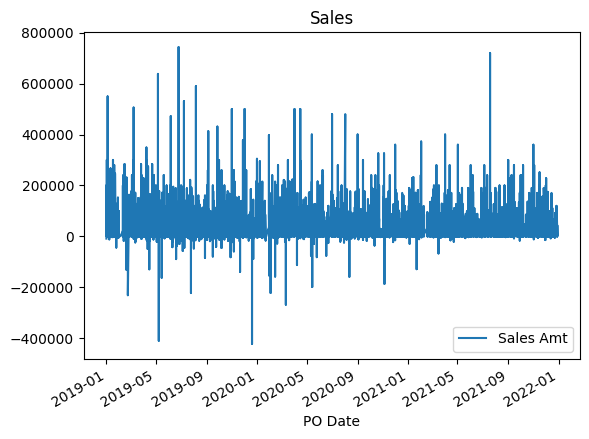

In [3]:
product_sales_info[['Sales Amt']].plot(title='Sales')

In [4]:
print(len(product_sales_info))
product_sales_info_without_nulls = product_sales_info[product_sales_info['Sales Amt'].notna()]
len(product_sales_info_without_nulls)

33289


33252

In [5]:
product_sales_info_without_nulls.head()

,Year,Month,Channel,Cust ID,Item,Qty,Sales Amt
PO Date,,,,,,,
2019-01-01,2019,1,AH,1300950362,CXB02,-30.0,-8544.0
2019-01-01,2019,1,AH,1300951458,EZA01,50.0,42714.0
2019-01-01,2019,1,AH,1300938625,LSN01,110.0,12407.0
2019-01-01,2019,1,AH,1300942430,LSN01,160.0,13824.0
2019-01-01,2019,1,AH,1300942783,LSN01,199.0,10613.0


In [6]:
product_sales_info = pd.DataFrame(product_sales_info_without_nulls[['Year', 'Month', 'Sales Amt']])
product_sales_info.head()

,Year,Month,Sales Amt
PO Date,,,
2019-01-01,2019,1,-8544.0
2019-01-01,2019,1,42714.0
2019-01-01,2019,1,12407.0
2019-01-01,2019,1,13824.0
2019-01-01,2019,1,10613.0


In [62]:
for col in product_sales_info:
    print(product_sales_info[col].unique())

[2019 2020 2021]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[-8544. 42714. 12407. ...  5097.  2549.   107.]
['2019-1' '2019-2' '2019-3' '2019-4' '2019-5' '2019-6' '2019-7' '2019-8'
 '2019-9' '2019-10' '2019-11' '2019-12' '2020-1' '2020-2' '2020-3'
 '2020-4' '2020-5' '2020-6' '2020-7' '2020-8' '2020-9' '2020-10' '2020-11'
 '2020-12' '2021-1' '2021-2' '2021-3' '2021-4' '2021-5' '2021-6' '2021-7'
 '2021-8' '2021-9' '2021-10' '2021-11' '2021-12']


In [7]:
product_sales_info['PO Date'] = product_sales_info['Year'].astype(str) + '-' + product_sales_info['Month'].astype(str)
product_sales_info.index = pd.to_datetime(product_sales_info['PO Date'])
resampled_df = product_sales_info.resample('M').sum()
print(len(resampled_df))
resampled_df.head()

36


C:\Users\kagitam\AppData\Local\Temp\ipykernel_21624\3571630858.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  resampled_df = product_sales_info.resample('M').sum()


,Year,Month,Sales Amt
PO Date,,,
2019-01-31,2596434,1286,22104774.0
2019-02-28,1259856,1248,7888127.0
2019-03-31,1728264,2568,13087760.0
2019-04-30,2142159,4244,16146615.0
2019-05-31,2037171,5045,12366224.0


In [8]:
holt_winters_df = resampled_df[['Sales Amt']]
holt_winters_df.head()

,Sales Amt
PO Date,
2019-01-31,22104774.0
2019-02-28,7888127.0
2019-03-31,13087760.0
2019-04-30,16146615.0
2019-05-31,12366224.0


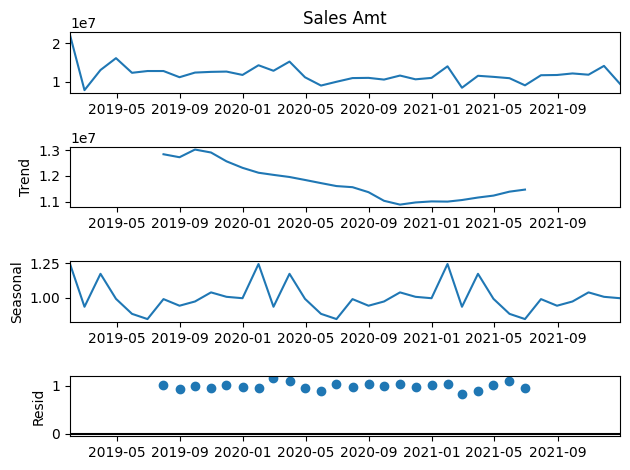

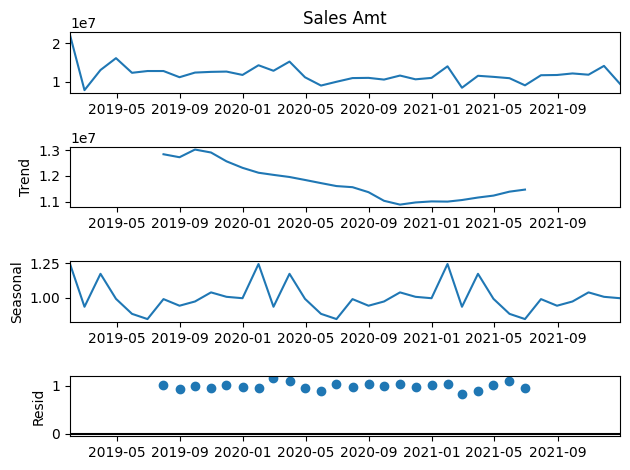

In [9]:
seasonal_decompose_result = seasonal_decompose(holt_winters_df['Sales Amt'], model='multiplicative', period=12)
seasonal_decompose_result.plot()

In [10]:
holt_winters_df.index.freq = 'M'
m = 12
alpha = 1/(2*m)
print(alpha)

0.041666666666666664


## Holt Winters Simple Exponential Smoothing

C:\Users\kagitam\AppData\Local\Temp\ipykernel_21624\3027670795.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  holt_winters_df['HWSES'] = SimpleExpSmoothing(holt_winters_df['Sales Amt']).fit(smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues


<AxesSubplot: title={'center': 'Holt Winters Simple Exponential Smoothing'}, xlabel='PO Date'>

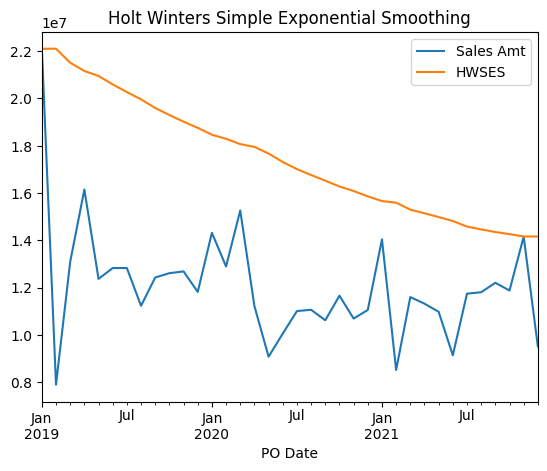

In [11]:
holt_winters_df['HWSES'] = SimpleExpSmoothing(holt_winters_df['Sales Amt']).fit(smoothing_level=alpha, optimized=False, use_brute=True).fittedvalues
holt_winters_df[['Sales Amt', 'HWSES']].plot(title='Holt Winters Simple Exponential Smoothing')

## Holt Winter Exponential Smoothing with Additive and Multiplicative trend

C:\Users\kagitam\.virtualenvs\Data_Developer-YGOcqH7r\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\kagitam\.virtualenvs\Data_Developer-YGOcqH7r\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot: title={'center': 'Holt Winters Exponential Smoothing: Additive and Multiplicative Trend'}, xlabel='PO Date'>

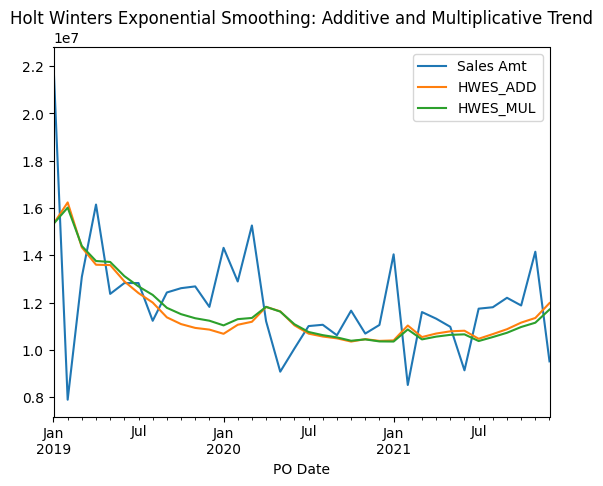

In [12]:
holt_winters_df['HWES_ADD'] = ExponentialSmoothing(holt_winters_df['Sales Amt'], trend='add').fit().fittedvalues
holt_winters_df['HWES_MUL'] = ExponentialSmoothing(holt_winters_df['Sales Amt'], trend='mul').fit().fittedvalues
holt_winters_df[['Sales Amt', 'HWES_ADD', 'HWES_MUL']].plot(title='Holt Winters Exponential Smoothing: Additive and Multiplicative Trend')

## Holt Winter Exponential Smoothing with Additive and Multiplicative Seasonality

C:\Users\kagitam\.virtualenvs\Data_Developer-YGOcqH7r\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\kagitam\.virtualenvs\Data_Developer-YGOcqH7r\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<AxesSubplot: title={'center': 'Holt Winters Exponential Smoothing: Additive and Multiplicative Seasonality'}, xlabel='PO Date'>

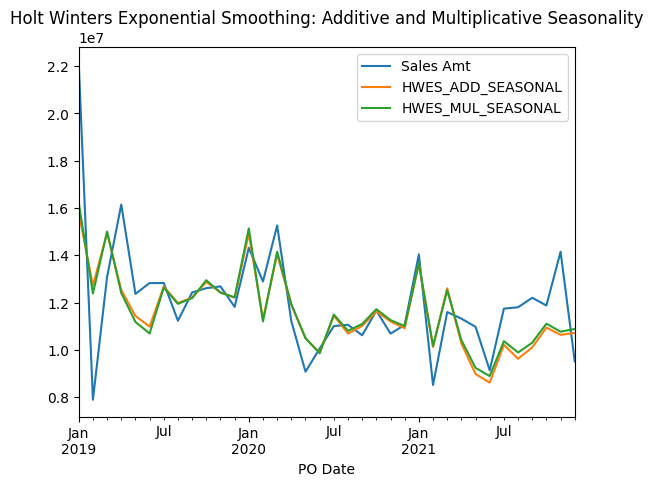

In [13]:
holt_winters_df['HWES_ADD_SEASONAL'] = ExponentialSmoothing(holt_winters_df['Sales Amt'],trend='add',seasonal='add',seasonal_periods=12).fit().fittedvalues
holt_winters_df['HWES_MUL_SEASONAL'] = ExponentialSmoothing(holt_winters_df['Sales Amt'],trend='mul',seasonal='mul',seasonal_periods=12).fit().fittedvalues
holt_winters_df[['Sales Amt','HWES_ADD_SEASONAL','HWES_MUL_SEASONAL']].plot(title='Holt Winters Exponential Smoothing: Additive and Multiplicative Seasonality')


In [16]:
resampled_df

,Year,Month,Sales Amt
PO Date,,,
2019-01-31,2596434,1286,22104774.0
2019-02-28,1259856,1248,7888127.0
2019-03-31,1728264,2568,13087760.0
2019-04-30,2142159,4244,16146615.0
2019-05-31,2037171,5045,12366224.0
2019-06-30,2059380,6120,12824906.0
2019-07-31,2245128,7784,12825375.0
2019-08-31,1968525,7800,11228008.0
2019-09-30,1944297,8667,12426177.0


In [20]:
train_test_split_ratio = 0.8
train_size = round(len(resampled_df) * train_test_split_ratio)
resampled_df = resampled_df[['Sales Amt']]
df_train = resampled_df[:train_size]
df_test = resampled_df[train_size:]
len(df_train)

29

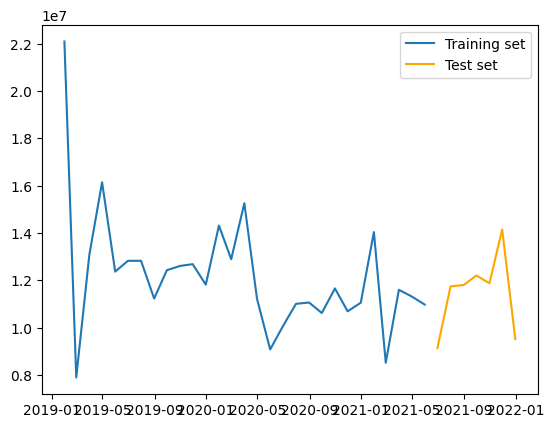

In [37]:
plt.plot(df_train, label='Training set')
plt.plot(df_test, label='Test set', color='orange')
plt.legend()

C:\Users\kagitam\.virtualenvs\Data_Developer-YGOcqH7r\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Text(0.5, 1.0, 'Train, Test and Predicted Test using Holt Winters')

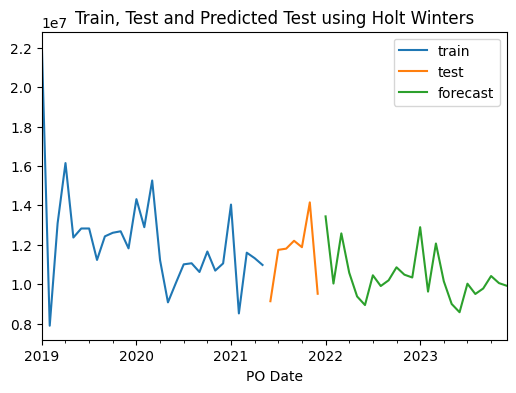

In [60]:
fitted_model = ExponentialSmoothing(resampled_df['Sales Amt'],trend='mul',seasonal='mul',seasonal_periods=12).fit()
forecast = fitted_model.forecast(24)
df_train['Sales Amt'].plot(legend=True,label='train')
df_test['Sales Amt'].plot(legend=True,label='test',figsize=(6,4))
forecast.plot(legend=True,label='forecast')
plt.title('Train, Test and Predicted Test using Holt Winters')

<AxesSubplot: xlabel='PO Date'>

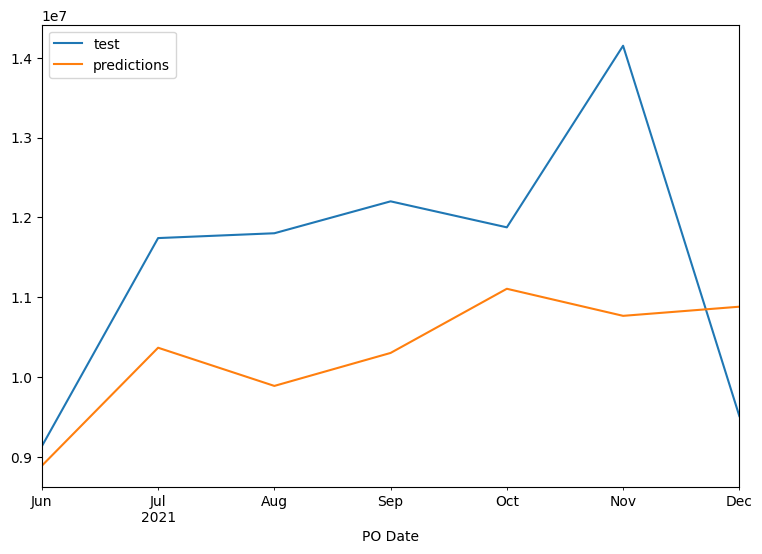

In [26]:
type(fitted_model)
predictions_on_test_data = fitted_model.predict(start=df_test.index[0], end=df_test.index[-1])
df_test['Sales Amt'].plot(legend=True,label='test',figsize=(9,6))
predictions_on_test_data.plot(legend=True,label='predictions',figsize=(9,6))

In [54]:
print(f'Mean Absolute Error: {mean_absolute_error(df_test,predictions_on_test_data)}')
print(f'Mean Squared Error: {mean_squared_error(df_test, predictions_on_test_data)}')

Mean Absolute Error: 1564913.6809742288
Mean Squared Error: 3305281840058.0864


In [56]:
rmse = lambda df_test, predictions_on_test_data: np.sqrt(mean_squared_error(df_test, predictions_on_test_data))
rmse

<function __main__.<lambda>(df_test, predictions_on_test_data)>

In [58]:
rmse = lambda act, pred: np.sqrt(mean_squared_error(act, pred))
print(f' RMSE: {rmse(df_test, predictions_on_test_data)}')

 RMSE: 1818043.4098387437


In [59]:
print(f'Mean Absolute Percentage Error: {mean_absolute_percentage_error(df_test, predictions_on_test_data)}')

Mean Absolute Percentage Error: 0.12993651828534497


### Add Cross validation - TimeSeriesSplit